<a href="https://colab.research.google.com/github/AluminumShark/Synthetic_Difference_in_Difference/blob/main/examples/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Synthetic Difference-in-Differences (SDID) Example

This notebook demonstrates how to use the `sdid` package to estimate causal effects using Synthetic Difference-in-Differences.

We will:
1. Generate synthetic panel data
2. Visualize raw trends (using `plot_raw_trends`)
3. Fit the SDID model
4. Visualize the synthetic control counterfactual (using `plot_synthetic_control`)
5. Estimate standard errors and run an event study

In [11]:
! pip install sdid
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sdid import SyntheticDiffInDiff

# Set random seed for reproducibility
np.random.seed(42)

## 1. Generate Synthetic Data

We'll create a balanced panel dataset with:
- 20 control units
- 1 treated unit
- 10 time periods (intervention at t=7)
- A strong time trend
- A treatment effect of +10

In [12]:
def generate_data():
    n_control = 20
    n_periods = 10
    treatment_start = 7

    # Note: We use one treated unit, labeled 'treated_0'
    units = [f"control_{i}" for i in range(n_control)] + ["treated_0"]
    times = range(1, n_periods + 1)

    data = []
    for unit in units:
        is_treated_unit = unit.startswith("treated")
        # Each unit has a random baseline level
        base_level = np.random.normal(100, 10)

        for t in times:
            # Time trend (common to all)
            time_trend = t * 2

            # Treatment effect (only for treated unit after start time)
            is_post = t >= treatment_start
            effect = 10 if (is_treated_unit and is_post) else 0

            # Random noise
            noise = np.random.normal(0, 1)

            outcome = base_level + time_trend + effect + noise

            data.append(
                {
                    "unit": unit,
                    "year": t,
                    "outcome": outcome,
                    "treated": is_treated_unit,
                    "post": is_post,
                }
            )

    return pd.DataFrame(data)


df = generate_data()
print("Data shape:", df.shape)
df.head()

Data shape: (210, 5)


unit  year     outcome  treated   post
0  control_0     1  106.828877    False  False
1  control_0     2  109.614830    False  False
2  control_0     3  112.490171    False  False
3  control_0     4  112.732988    False  False
4  control_0     5  114.733005    False  False

## 2. Initialize SDID and Visualize Raw Trends

Before fitting the model, it's useful to look at the raw data. The new `plot_raw_trends()` method makes this easy. This replaces the need for manual matplotlib loops to plot each control unit.

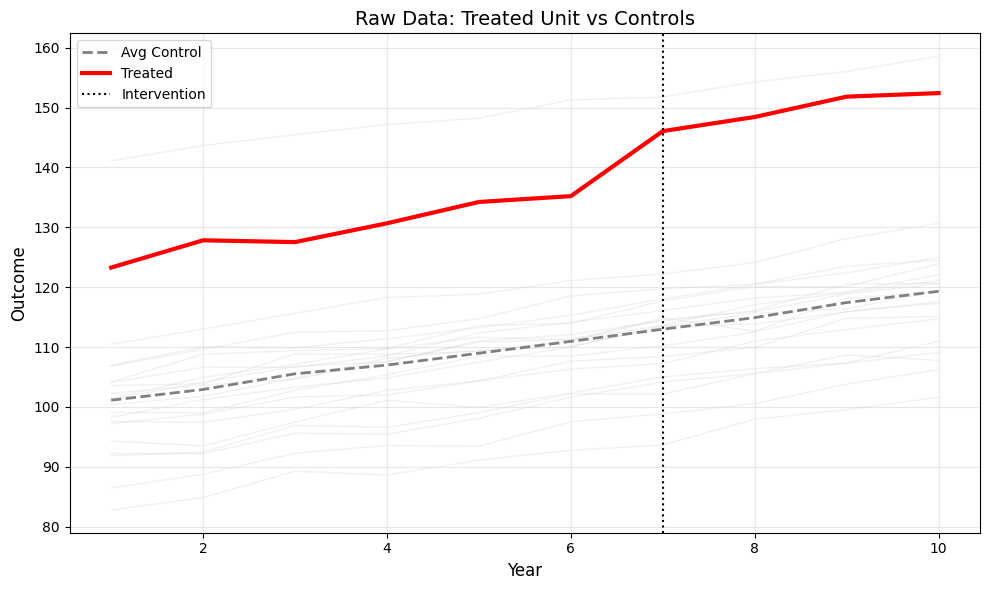

In [13]:
# Initialize the estimator
sdid = SyntheticDiffInDiff(
    data=df,
    outcome_col="outcome",
    times_col="year",
    units_col="unit",
    treat_col="treated",
    post_col="post",
)

# Visualize raw trends using the new method
sdid.plot_raw_trends(title="Raw Data: Treated Unit vs Controls")
plt.show()

## 3. Fit the Model

The `fit()` method estimates:
- Unit weights (to match pre-treatment trends)
- Time weights (to balance pre-treatment periods)
- The treatment effect (ATT)

In [14]:
att = sdid.fit()

print(f"Estimated Treatment Effect (ATT): {att:.4f}")
print("True Treatment Effect: 10.0000")

Estimated Treatment Effect (ATT): 15.4010
True Treatment Effect: 10.0000


## 4. Visualize Synthetic Control

Now we can see how well the SDID estimator constructed a synthetic control. The `plot_synthetic_control()` method shows the treated unit against the weighted combination of control units. This visualization helps verify if the pre-treatment trends are well-matched.

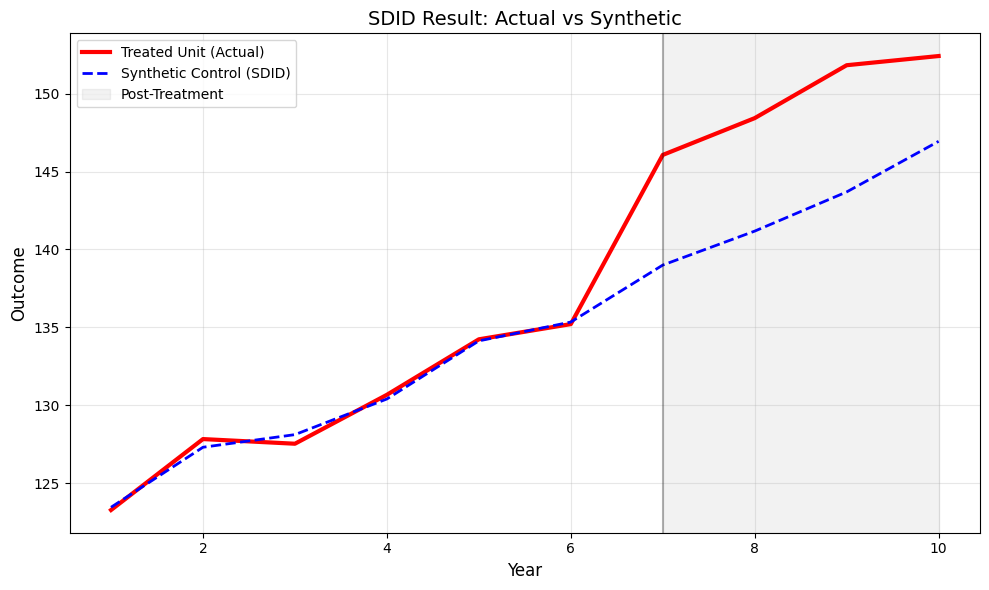

In [15]:
# Visualize synthetic control using the new method
sdid.plot_synthetic_control(title="SDID Result: Actual vs Synthetic")
plt.show()

## 5. Weights Analysis

Let's see which control units contributed most to the synthetic control.

In [16]:
weights = sdid.get_weights_summary()

print("Top 5 Control Units by Weight:")
print(weights["unit_weights"].head())

Top 5 Control Units by Weight:
              weight  rank
unit                      
control_15  0.305186   1.0
control_13  0.272875   2.0
control_14  0.251732   3.0
control_6   0.222922   4.0
control_18  0.220052   5.0


## 6. Inference and Event Study

Finally, we can estimate standard errors and run an event study to check for pre-trends and dynamic effects.

In [17]:
# Estimate Standard Error (using bootstrap)
se = sdid.estimate_se(n_bootstrap=50)

print("Standard Summary (95% CI):")
print(sdid.summary())

Standard Summary (95% CI):
Synthetic Difference-in-Differences Results
Treatment Effect (ATT): 15.4010
Standard Error:        5.4943
95% Confidence Interval: [4.6324, 26.1696]
t-statistic:           2.8031
p-value:               0.0051
Control units used:    5
Time periods used:     0


In [18]:
print("Summary with 90% Confidence Interval:")
print(sdid.summary(confidence_level=0.95))

Summary with 90% Confidence Interval:
Synthetic Difference-in-Differences Results
Treatment Effect (ATT): 15.4010
Standard Error:        5.4943
95% Confidence Interval: [4.6324, 26.1696]
t-statistic:           2.8031
p-value:               0.0051
Control units used:    5
Time periods used:     0


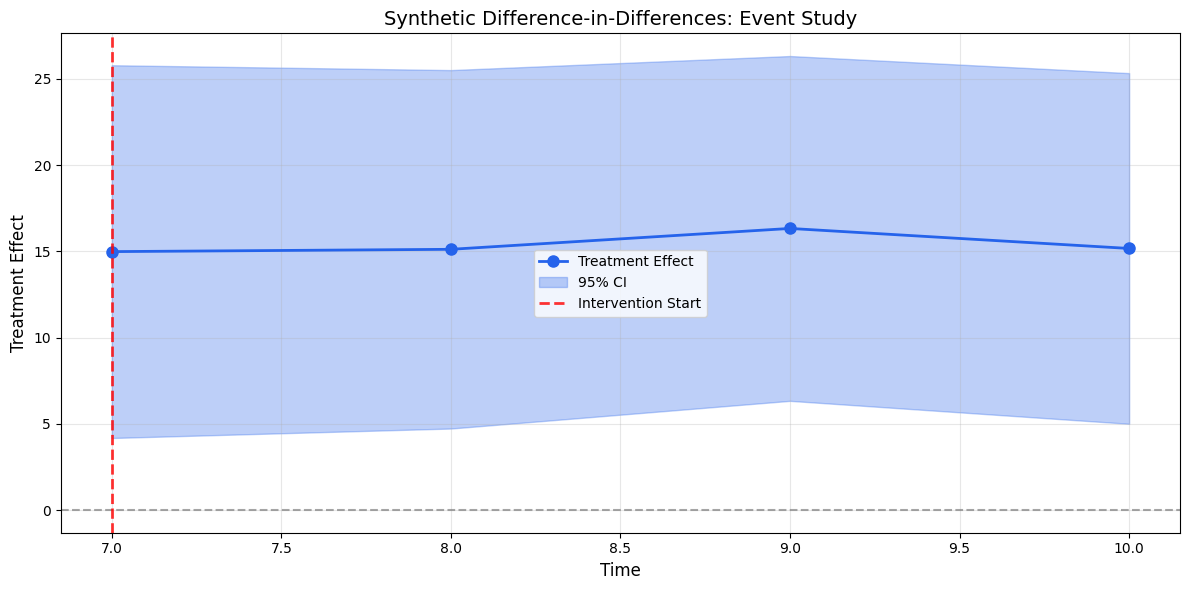

In [19]:
# Event Study Plot
sdid.plot_event_study(times=list(range(7, 11)), confidence_level=0.95)
plt.show()